### 개요
타이타닉은 역사상 가장 유명한 난파선 중 하나입니다.

1912년 4월 15일, 타이타닉은 항해중 빙산과의 충돌로 인해 침몰합니다. 탑승인원 2224명 중 1502명이 사망한 비극적인 사건이었고, 선박의 안전규정을 개선시키는 계기가 되었습니다.

이 과제에서는 여러분은 어떤 종류의 사람들이 많이 살아남았는지에 대한 분석을 해야 합니다.
그리고 머신러닝을 이용해 어떤 승객이 생존했을지 예측해보세요.

### 규칙
평가지표 : AUC

### 컬럼
- PassengerId : 탑승객의 고유 아이디
- Survived : 생존유무(0 사망, 1 생존)
- Pclass : 등실의 등급
- Name : 이름
- Sex : 성별
- Age : 나이
- SibSp : 함께 탑승한 형제자매, 아내, 남편의 수
- Parch : 함께 탑승한 부모, 자식의 수
- Ticket : 티켓번호
- Fare : 티켓의 요금
- Cabin : 객실번호
- Embarked : 배에 탑승한 위치(C = Cherbourg, Q = Queenstown, S = Southampton)

### 1. Import

In [76]:
# Data Wrangling
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder # 라벨 인코더
from sklearn.preprocessing import OneHotEncoder # 원핫 인코더
from sklearn.impute import SimpleImputer # 결측값 처리
from sklearn.preprocessing import StandardScaler # 스케일러 - 분류문제 유용
from sklearn.preprocessing import MinMaxScaler # 스케일러 - 회귀문제 유용
from imblearn.over_sampling import SMOTE # 오버샘플링
from imblearn.under_sampling import * # 언더샘플링
from scipy.stats import skew, kurtosis # 왜도, 첨도
from sklearn.decomposition import PCA

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import plot_importance
from sklearn.metrics import roc_curve
import shap

# Modeling
from lightgbm import LGBMClassifier

# Evaluation
from sklearn.model_selection import cross_val_score

# Utility
import os
import pickle
import warnings; warnings.filterwarnings(action='ignore') # warning 메시지 안보이기
from tqdm import tqdm # 진행률 확인
from sklearn.model_selection import train_test_split # train, test 분리

### 2. Read

In [77]:
# 파일 불러오기
train=pd.read_csv(os.path.abspath("../input")+'/train.csv')
test=pd.read_csv(os.path.abspath("../input")+'/test.csv')
submission=pd.read_csv(os.path.abspath("../input")+'/submission.csv')

In [78]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [79]:
test.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [80]:
submission.head(3)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0


In [81]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [82]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [83]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB


In [84]:
train.shape, test.shape, submission.shape

((891, 12), (418, 11), (418, 2))

### 3. Pre Data Processing

#### 3.1. Settings

In [85]:
# index 설정
train.set_index('PassengerId', inplace=True)
test.set_index('PassengerId', inplace=True)

In [86]:
# train, test 병합
df = pd.concat([train, test])

In [87]:
# 범주형과 수치형 분리
features_cat = train.select_dtypes(include=['object']).columns.to_list()
features_num = train.select_dtypes(exclude='object').drop(['Survived'], axis=1).columns.to_list()
print('범주형 :', features_cat)
print('수치형 :', features_num)

범주형 : ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
수치형 : ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


#### 3.2. Processing

##### 3.2.1. Object

*1) Name*

In [88]:
print('범주 수 :', df['Name'].nunique())
print('결측치 수 :', df['Name'].isnull().sum())
print('===============')
print(df['Name'].value_counts())

범주 수 : 1307
결측치 수 : 0
Kelly, Mr. James                                        2
Connolly, Miss. Kate                                    2
Bidois, Miss. Rosalie                                   1
Humblen, Mr. Adolf Mathias Nicolai Olsen                1
Rice, Master. Arthur                                    1
                                                       ..
Willey, Mr. Edward                                      1
Emir, Mr. Farred Chehab                                 1
Rice, Master. Eric                                      1
Hakkarainen, Mrs. Pekka Pietari (Elin Matilda Dolck)    1
Hassab, Mr. Hammad                                      1
Name: Name, Length: 1307, dtype: int64


In [89]:
df['Title'] = df['Name'].str.split(', ').str[1].str.split('. ').str[0]

In [90]:
print('범주 수 :', df['Title'].nunique())
print('결측치 수 :', df['Title'].isnull().sum())
print('===============')
print(df['Title'].value_counts())

범주 수 : 18
결측치 수 : 0
Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Ms            2
Major         2
th            1
Capt          1
Mme           1
Sir           1
Dona          1
Don           1
Jonkheer      1
Lady          1
Name: Title, dtype: int64


In [91]:
df['Title'] = np.where((df['Title']!='Mr')&(df['Title']!='Miss')&(df['Title']!='Mrs')&(df['Title']!='Master'), 'Etc', df['Title'])

In [92]:
print('범주 수 :', df['Title'].nunique())
print('결측치 수 :', df['Title'].isnull().sum())
print('===============')
print(df['Title'].value_counts())

범주 수 : 5
결측치 수 : 0
Mr        757
Miss      260
Mrs       197
Master     61
Etc        34
Name: Title, dtype: int64


In [93]:
df.drop(['Name'], axis=1, inplace=True)

*2) Sex*

In [94]:
print('범주 수 :', df['Sex'].nunique())
print('결측치 수 :', df['Sex'].isnull().sum())
print('===============')
print(train['Sex'].value_counts())

범주 수 : 2
결측치 수 : 0
male      577
female    314
Name: Sex, dtype: int64


*3) Ticket*

In [95]:
print('범주 수 :', df['Ticket'].nunique())
print('결측치 수 :', df['Ticket'].isnull().sum())
print('===============')
print(df['Ticket'].value_counts())

범주 수 : 929
결측치 수 : 0
CA. 2343              11
1601                   8
CA 2144                8
S.O.C. 14879           7
347082                 7
                      ..
315084                 1
250643                 1
366713                 1
2671                   1
SOTON/O.Q. 3101305     1
Name: Ticket, Length: 929, dtype: int64


In [96]:
df['Ticket_type'] = np.where(df['Ticket'].str.isnumeric(),'num','str')

In [97]:
print('범주 수 :', df['Ticket_type'].nunique())
print('결측치 수 :', df['Ticket_type'].isnull().sum())
print('===============')
print(df['Ticket_type'].value_counts())

범주 수 : 2
결측치 수 : 0
num    957
str    352
Name: Ticket_type, dtype: int64


In [98]:
df.drop(['Ticket'], axis=1, inplace=True)

*4) Cabin*

In [99]:
print('범주 수 :', df['Cabin'].nunique())
print('결측치 수 :', df['Cabin'].isnull().sum())
print('===============')
print(df['Cabin'].value_counts())

범주 수 : 186
결측치 수 : 1014
C23 C25 C27        6
G6                 5
B57 B59 B63 B66    5
F4                 4
F33                4
                  ..
C90                1
E17                1
C103               1
C49                1
A18                1
Name: Cabin, Length: 186, dtype: int64


In [100]:
df['Cabin_nan'] = np.where(df['Cabin'].isnull(), 0, 1).astype('object')

In [101]:
print('범주 수 :', df['Cabin_nan'].nunique())
print('결측치 수 :', df['Cabin_nan'].isnull().sum())
print('===============')
print(df['Cabin_nan'].value_counts())

범주 수 : 2
결측치 수 : 0
0    1014
1     295
Name: Cabin_nan, dtype: int64


In [102]:
df['Cabin_num'] = np.where(df['Cabin'].str.len()<=4,1,np.where(df['Cabin'].str.len()<=7,2,np.where(df['Cabin'].str.len()<=11,3,np.where(df['Cabin'].str.len()<=15,4,0))))

In [103]:
print('범주 수 :', df['Cabin_num'].nunique())
print('결측치 수 :', df['Cabin_num'].isnull().sum())
print('===============')
print(df['Cabin_num'].value_counts())

범주 수 : 5
결측치 수 : 0
0    1014
1     254
2      26
3      10
4       5
Name: Cabin_num, dtype: int64


In [104]:
df['Cabin_type'] = np.where(df['Cabin'].isnull(), 'X', df['Cabin'].str[0])

In [105]:
print('범주 수 :', df['Cabin_type'].nunique())
print('결측치 수 :', df['Cabin_type'].isnull().sum())
print('===============')
print(df['Cabin_type'].value_counts())

범주 수 : 9
결측치 수 : 0
X    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: Cabin_type, dtype: int64


In [106]:
df.drop(['Cabin'], axis=1, inplace=True)

*5) Embarked*

In [107]:
print('범주 수 :', df['Embarked'].nunique())
print('결측치 수 :', df['Embarked'].isnull().sum())
print('===============')
print(df['Embarked'].value_counts())

범주 수 : 3
결측치 수 : 2
S    914
C    270
Q    123
Name: Embarked, dtype: int64


##### 3.2.2. Numeric

*1) Pclass*

In [108]:
print('결측치 수 :', df['Pclass'].isnull().sum())
print('=======t=======')
print(df['Pclass'].value_counts().sort_index())

결측치 수 : 0
=======t=======
1    323
2    277
3    709
Name: Pclass, dtype: int64


In [109]:
df['Pclass'] = df['Pclass'].astype('object')

*2) Age*

In [110]:
print('결측치 수 :', df['Age'].isnull().sum())
print('===============')
print(df['Age'].value_counts().sort_index())

결측치 수 : 263
0.17     1
0.33     1
0.42     1
0.67     1
0.75     3
        ..
70.50    1
71.00    2
74.00    1
76.00    1
80.00    1
Name: Age, Length: 98, dtype: int64


In [111]:
df['Age_type'] = np.where(df['Age']<10,0,np.where(df['Age']<20,1,np.where(df['Age']<30,2,np.where(df['Age']<40,3,np.where(df['Age']<50,4,np.where(df['Age']<60,5,np.where(df['Age']<70,6,np.where(df['Age']<200,7,df['Age'])))))))).astype('object')

In [112]:
print('결측치 수 :', df['Age_type'].isnull().sum())
print('===============')
print(df['Age_type'].value_counts().sort_index())

결측치 수 : 263
0.0     82
1.0    143
2.0    344
3.0    232
4.0    135
5.0     70
6.0     32
7.0      8
Name: Age_type, dtype: int64


*3) SibSp*

In [113]:
print('결측치 수 :', df.SibSp.isnull().sum())
print('===============')
print(df.SibSp.value_counts().sort_index())

결측치 수 : 0
0    891
1    319
2     42
3     20
4     22
5      6
8      9
Name: SibSp, dtype: int64


*4) Parch*

In [114]:
print('결측치 수 :', df.Parch.isnull().sum())
print('===============')
print(df.Parch.value_counts().sort_index())

결측치 수 : 0
0    1002
1     170
2     113
3       8
4       6
5       6
6       2
9       2
Name: Parch, dtype: int64


*5) Fare*

In [115]:
print('결측치 수 :', df.Fare.isnull().sum())
print('===============')
print(df.Fare.value_counts().sort_index())

결측치 수 : 1
0.0000      17
3.1708       1
4.0125       1
5.0000       1
6.2375       1
            ..
227.5250     5
247.5208     3
262.3750     7
263.0000     6
512.3292     4
Name: Fare, Length: 281, dtype: int64


#### 3.4. Divide

In [116]:
# df에서 train, test 분리
train = df[:len(train)]
test = df[len(train):].drop(['Survived'], axis=1) # test에서 Target 제거

### 4. EDA

#### 4.1. Settings

In [117]:
# 수치형과 범주형 분리
features_cat = train.select_dtypes(include=['object']).columns.to_list()
features_num = train.select_dtypes(exclude='object').drop(['Survived'], axis=1).columns.to_list()

In [118]:
fig = plt.figure(figsize=(6,4)) # 그래프 사이즈
sns.set_style('white') # 그래프 배경 색 설정

<Figure size 432x288 with 0 Axes>

#### 4.2. Target

0.0    0.616162
1.0    0.383838
Name: Survived, dtype: float64


<AxesSubplot:xlabel='Survived', ylabel='count'>

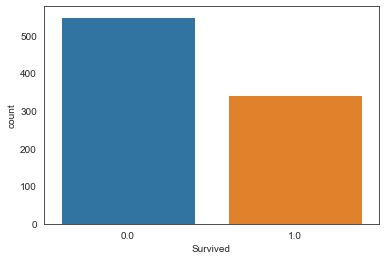

In [119]:
print(train.Survived.value_counts(normalize=True)) # Target 비율
sns.countplot(x='Survived', data=train) # Target 수 그래프

#### 4.3. Object

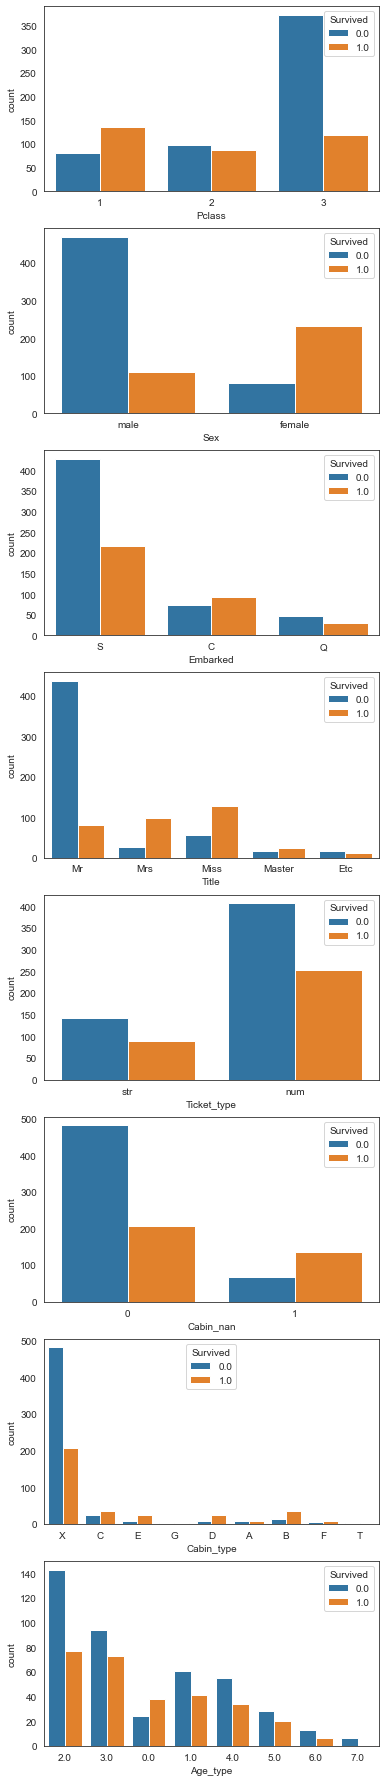

In [120]:
fig, ax = plt.subplots(nrows=len(features_cat), figsize=(6, 4*len(features_cat)))
for i in range(len(features_cat)):
    sns.countplot(x=features_cat[i], hue='Survived', data=train, ax=ax[i])

#### 4.4. Numeric

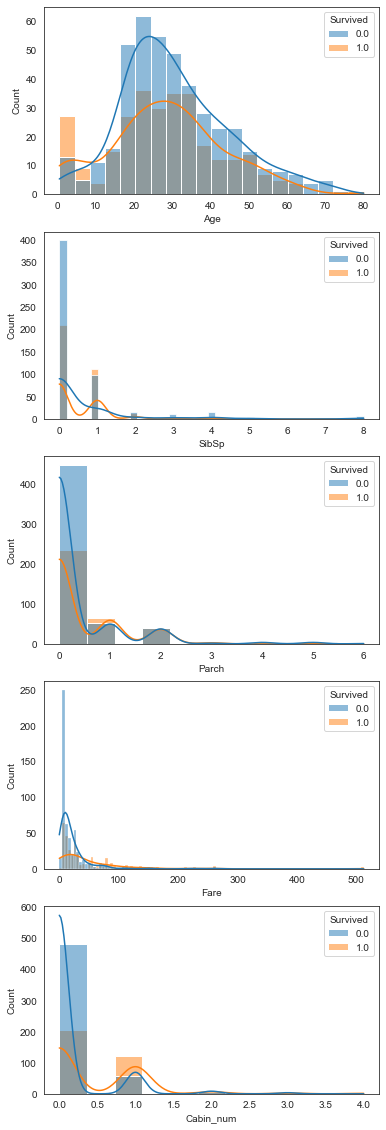

In [121]:
fig, ax = plt.subplots(nrows=len(features_num), figsize=(6, 4*len(features_num)))
for i in range(len(features_num)):
    sns.histplot(x=features_num[i], hue='Survived', data=train, kde=True, ax=ax[i])

<Figure size 2160x1440 with 0 Axes>

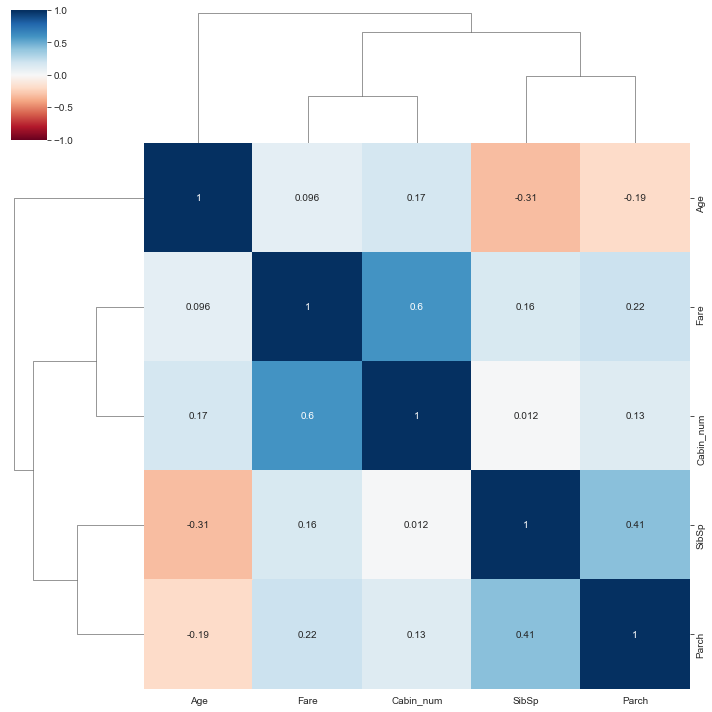

In [122]:
fig = plt.figure(figsize=(6*len(features_num),4*len(features_num))) # 그래프 사이즈
sns.clustermap(train[features_num].corr(), annot=True, cmap='RdBu', vmin=-1, vmax=1)

#### 4.5. Missing Value

In [123]:
# train, test 병합
df = pd.concat([train, test])

<AxesSubplot:ylabel='PassengerId'>

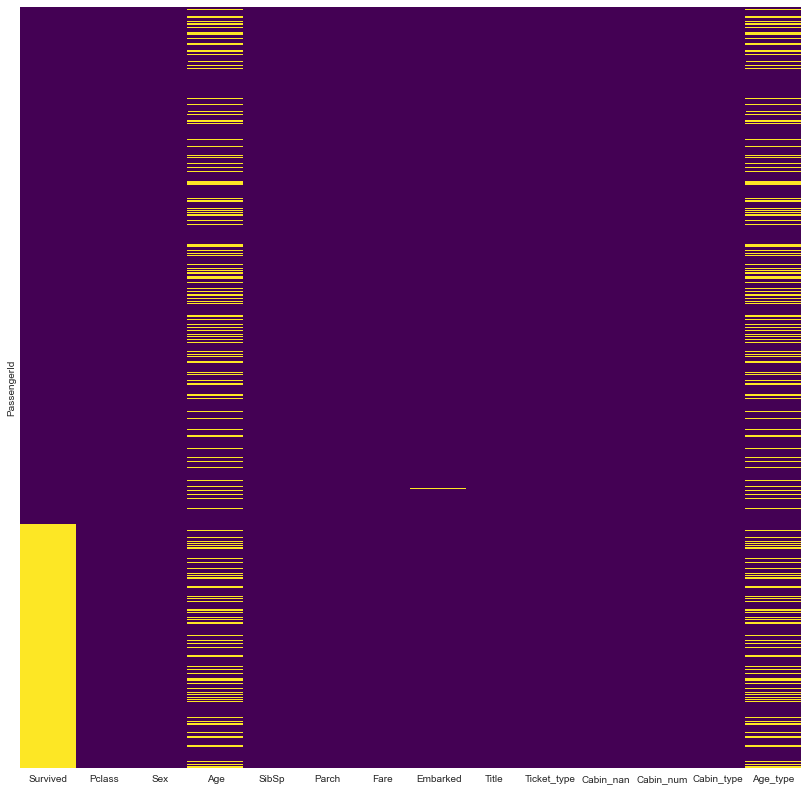

In [124]:
fig = plt.figure(figsize=(len(df.columns),len(df.columns))) # 그래프 사이즈
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

### 5. Processing

#### 5.1. Settings

In [125]:
# 수치형과 범주형 분리
features_num = train.drop(['Survived'], axis=1).select_dtypes(exclude='object').columns.to_list()
features_cat = train.drop(['Survived'], axis=1).select_dtypes(include=['object']).columns.to_list()

#### 5.2. Missing Value

In [126]:
df.isnull().sum()

Survived       418
Pclass           0
Sex              0
Age            263
SibSp            0
Parch            0
Fare             1
Embarked         2
Title            0
Ticket_type      0
Cabin_nan        0
Cabin_num        0
Cabin_type       0
Age_type       263
dtype: int64

*1) Age*

In [127]:
# 결측치 처리 전 결측치 수 확인
print(train.Age.isnull().sum())
print(test.Age.isnull().sum())

177
86


In [128]:
# 결측치 처리
train['Age'] = train['Age'].fillna(train.groupby('Title')['Age'].transform('mean'))
test['Age'] = test['Age'].fillna(test.groupby('Title')['Age'].transform('mean'))

In [129]:
# 결측치 처리 후 결측치 수 확인
print(train.Age.isnull().sum())
print(test.Age.isnull().sum())

0
0


*2) Fare*

In [130]:
# 결측치 처리 후 결측치 수 확인
print(train.Fare.isnull().sum())
print(test.Fare.isnull().sum())

0
1


In [131]:
# 결측치 처리
test['Fare'] = test['Fare'].fillna(test.groupby('Pclass')['Fare'].transform('mean'))

In [132]:
# 결측치 처리 후 결측치 수 확인
print(train.Age.isnull().sum())
print(test.Age.isnull().sum())

0
0


*3) Embarked*

In [133]:
# 결측치 처리 후 결측치 수 확인
print(train.Embarked.isnull().sum())
print(test.Embarked.isnull().sum())

2
0


In [134]:
# 결측 데이터 확인
train[train['Embarked'].isnull()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Ticket_type,Cabin_nan,Cabin_num,Cabin_type,Age_type
PassengerId,,,,,,,,,,,,,,
62,1.0,1,female,38.0,0,0,80.0,NaN,Miss,num,1,1,B,3
830,1.0,1,female,62.0,0,0,80.0,NaN,Mrs,num,1,1,B,6


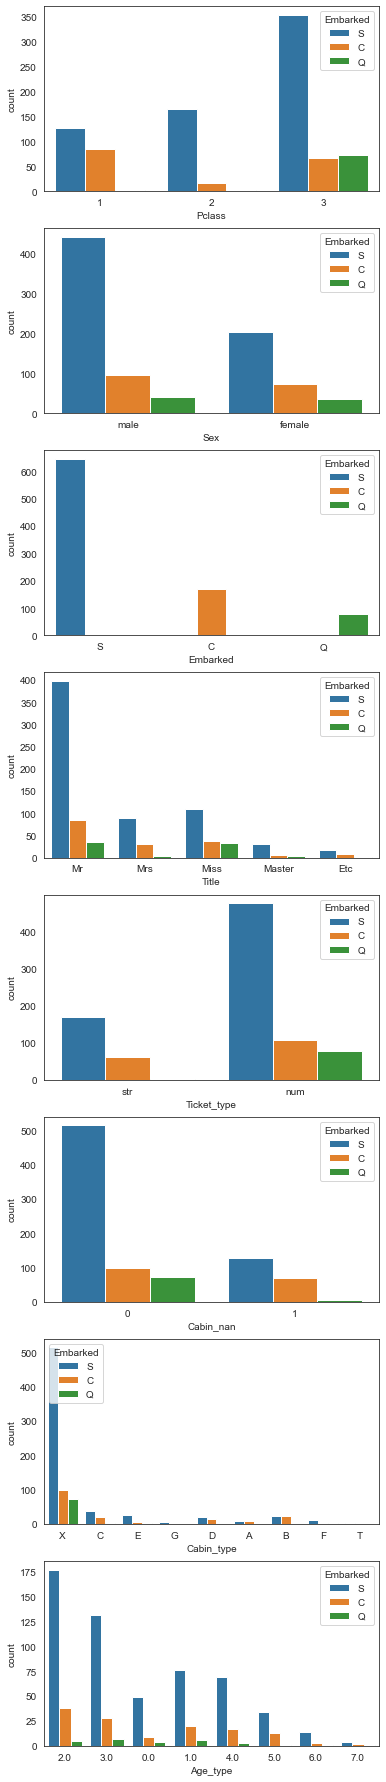

In [135]:
fig, ax = plt.subplots(nrows=len(features_cat), figsize=(6, 4*len(features_cat)))
for i in range(len(features_cat)):
    sns.countplot(x=features_cat[i], hue='Embarked', data=train, ax=ax[i])

In [136]:
# 결측 데이터의 Pclass에 따라 결측치 처리
train['Embarked'] = train['Embarked'].fillna('S')

In [137]:
# 결측치 처리 후 결측치 수 확인
print(train.Embarked.isnull().sum())
print(test.Embarked.isnull().sum())

0
0


#### 5.3. Skew

In [138]:
for i in range(len(features_num)):
    print(f'train 데이터 {features_num[i]} 왜도값 :', skew(train[features_num[i]]))
    if np.abs(skew(train[features_num[i]]))>1: # 왜도 절대값이 1보다 크면
        if np.min(train[features_num[i]]) <= 0:
            train[features_num[i]] = train[features_num[i]] + (np.min(train[features_num[i]])+1)
            test[features_num[i]] = test[features_num[i]] + (np.min(test[features_num[i]])+1)
        train[features_num[i]] = np.log(train[features_num[i]]) # train 루트 변환 실시
        test[features_num[i]] = np.log(test[features_num[i]]) # test 루트 변환 실시
    print(f'train 데이터 {features_num[i]} 왜도값 :', skew(train[features_num[i]]))
    print('=============================================')

train 데이터 Age 왜도값 : 0.35958757155463517
train 데이터 Age 왜도값 : 0.35958757155463517
train 데이터 SibSp 왜도값 : 3.6891276847759507
train 데이터 SibSp 왜도값 : 1.6584474020634181
train 데이터 Parch 왜도값 : 2.7444867379203735
train 데이터 Parch 왜도값 : 1.672617530182256
train 데이터 Fare 왜도값 : 4.7792532923723545
train 데이터 Fare 왜도값 : 0.39426283638993376
train 데이터 Cabin_num 왜도값 : 2.5226207922600223
train 데이터 Cabin_num 왜도값 : 1.6263530942733238


#### 5.4. Outlier

<AxesSubplot:>

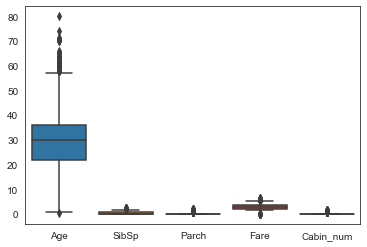

In [139]:
# 이상치 확인
sns.boxplot(data=train[features_num])

In [140]:
# 이상치 개수 확인 함수 생성
def outlier_count(df, col):
    q25 = np.quantile(df[col], 0.25)
    q75 = np.quantile(df[col], 0.75)
    
    iqr = q75-q25
    cut_off = iqr*1.5
    
    lower = q25-cut_off
    upper = q75+cut_off
    
    df1 = df[df[col]>upper]
    df2 = df[df[col]<lower]
    
    return df1.shape[0]+df2.shape[0]

# 이상치 개수 확인
for i in range(len(features_num)):
    print(features_num[i]," : ", outlier_count(train,features_num[i]),"  ", round(outlier_count(train,features_num[i])/len(train)*100,1),"%")

Age  :  34    3.8 %
SibSp  :  12    1.3 %
Parch  :  213    23.9 %
Fare  :  31    3.5 %
Cabin_num  :  204    22.9 %


In [141]:
'''
# 이상치 제거
train[features_num] = train[features_num].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)
'''

'\n# 이상치 제거\ntrain[features_num] = train[features_num].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)\n'

Age  :  34    3.8 %
SibSp  :  12    1.3 %
Parch  :  213    23.9 %
Fare  :  31    3.5 %
Cabin_num  :  204    22.9 %


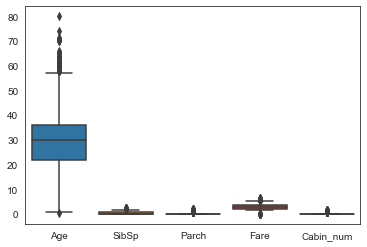

In [142]:
# 최종 이상치 확인
sns.boxplot(data=train[features_num])

for i in range(len(features_num)):
    print(features_num[i]," : ", outlier_count(train,features_num[i]),"  ", round(outlier_count(train,features_num[i])/len(train)*100,1),"%")

#### 5.5. Scaling

In [143]:
scaler = StandardScaler()
train[features_num] = scaler.fit_transform(train[features_num])
test[features_num] = scaler.transform(test[features_num])

#### 5.6. Encoding

In [144]:
# train, test 병합
df = pd.concat([train, test])

In [145]:
# 라벨 인코딩 실시
le = LabelEncoder() # LabelEncoder 불러오기

for feature in features_cat:
    le.fit(df[feature])
    df[feature] = le.transform(df[feature])

In [146]:
'''
# 원핫 인코딩 실시
ohe = OneHotEncoder(sparse=False) # OneHotEncoder 불러오기

for i in range(len(features_cat_ohe)):
    cat_ohe = ohe.fit_transform(df[[features_cat_ohe[i]]]).astype(int)
    df_ohe = pd.DataFrame(cat_ohe, columns=features_cat_ohe[i]+'_'+ohe.categories_[0])
    df = pd.concat([df.reset_index(), df_ohe], axis=1)
    df = df.set_index('PassengerId')
    df.drop([features_cat_ohe[i]], axis=1, inplace=True)
'''

"\n# 원핫 인코딩 실시\nohe = OneHotEncoder(sparse=False) # OneHotEncoder 불러오기\n\nfor i in range(len(features_cat_ohe)):\n    cat_ohe = ohe.fit_transform(df[[features_cat_ohe[i]]]).astype(int)\n    df_ohe = pd.DataFrame(cat_ohe, columns=features_cat_ohe[i]+'_'+ohe.categories_[0])\n    df = pd.concat([df.reset_index(), df_ohe], axis=1)\n    df = df.set_index('PassengerId')\n    df.drop([features_cat_ohe[i]], axis=1, inplace=True)\n"

In [147]:
# df에서 train, test 분리
train = df[:len(train)]
test = df[len(train):].drop(['Survived'], axis=1) # test에서 Target 제거

### 6. Feature Create

In [209]:
train['Family_num'] = train['SibSp'] + train['Parch'] + 1
test['Family_num'] = test['SibSp'] + test['Parch'] + 1

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Ticket_type,Cabin_nan,Cabin_num,Cabin_type,Age_type,Family_num
PassengerId,,,,,,,,,,,,,,,
1,0.0,2,1,-0.584402,0.889164,-0.529060,-0.879741,2,3,1,0,-0.526348,8,2,1.360104
2,1.0,0,0,0.621313,0.889164,-0.529060,1.361220,0,4,1,1,1.586127,2,3,1.360104
3,1.0,2,0,-0.282973,-0.609279,-0.529060,-0.798540,2,2,1,0,-0.526348,8,2,-0.138340
4,1.0,0,0,0.395242,0.889164,-0.529060,1.062038,2,4,0,1,1.586127,2,3,1.360104
5,0.0,2,1,0.395242,-0.609279,-0.529060,-0.784179,2,3,0,0,-0.526348,8,3,-0.138340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0.0,1,1,-0.207616,-0.609279,-0.529060,-0.333698,2,0,0,0,-0.526348,8,2,-0.138340
888,1.0,0,0,-0.810474,-0.609279,-0.529060,0.487082,2,2,0,1,1.586127,1,1,-0.138340
889,0.0,2,0,-0.601435,0.889164,2.141043,0.242007,2,2,1,0,-0.526348,8,8,4.030207


### 7. Baseline

#### 7.1. Settings

In [148]:
features = train.drop(['Survived'], axis=1).columns
features

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title',
       'Ticket_type', 'Cabin_nan', 'Cabin_num', 'Cabin_type', 'Age_type'],
      dtype='object')

In [149]:
X_train = train[features]
X_test = test[features]
y_train = train['Survived']

In [151]:
train_id = train.reset_index()['PassengerId']
test_id = test.reset_index()['PassengerId']

#### 7.2. Modeling

In [154]:
# train & valid split
valid_rate = len(X_test)/len(X_train)
X_train_split, X_valid, y_train_split, y_valid = train_test_split(X_train, y_train, test_size=valid_rate, random_state=5)

In [207]:
lgbm = LGBMClassifier()
lgbm.fit(X_train_split, y_train_split)
train_score = cross_val_score(lgbm, X_train_split, y_train_split, cv=3, scoring='accuracy')
print('train_score :', round(train_score.mean(),5))
print('valid_score :', round(lgbm.score(X_valid, y_valid),5))

train_score : 0.83289
valid_score : 0.8134


#### 7.3. Feature Select with Shap

In [159]:
explainer = shap.TreeExplainer(lgbm)
shap_values = explainer.shap_values(X_test)

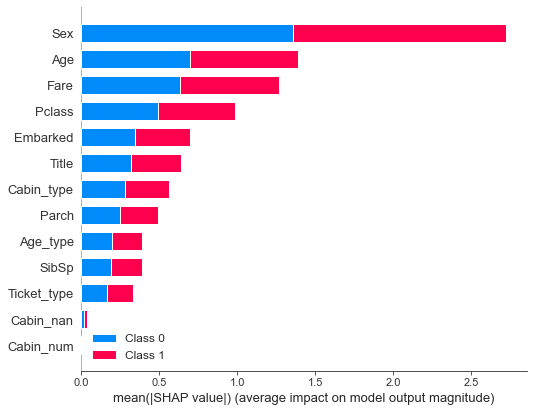

In [160]:
shap.summary_plot(shap_values, X_test, max_display=20) # max_display : 그래프에 보여줄 피쳐 수

In [196]:
shap_sum = np.abs(shap_values).mean(axis=0).mean(axis=0)*2
importance_df = pd.DataFrame([X_test.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['col_name', 'shap_values']
importance_df = importance_df.sort_values('shap_values', ascending=False)
importance_df

,col_name,shap_values
1,Sex,2.72186
2,Age,1.39321
5,Fare,1.26804
0,Pclass,0.986967
6,Embarked,0.696427
7,Title,0.642608
11,Cabin_type,0.562885
4,Parch,0.495814
12,Age_type,0.394791
3,SibSp,0.391573


In [ ]:
# importance_df[importance_df['col_name']=='F3TZASCIERN']

#### 7.4. Pickle Save

In [206]:
# 단일 pickle 파일 생성
print('초기 피쳐 수 :', len(features))
features_shap = importance_df.query('shap_values > 0').col_name.tolist() # shap_value 기준 컬럼 선택
print('shap_value 기반 피쳐 수 :', len(features_shap))

X_train_shap = X_train[features_shap]
X_test_shap = X_test[features_shap]

# pickle 형식으로 저장
org_data = (X_train_shap, y_train, X_test_shap, test_id)
with open(f'p1_data_{len(features_shap)}.pkl', 'wb') as f:
    pickle.dump(org_data, f)
print(f'p1_data_{len(features_shap)}.pkl is ready to submit.')

초기 피쳐 수 : 13
shap_value 기반 피쳐 수 : 13
p1_data_13.pkl is ready to submit.


In [ ]:
'''
# 다수 pickle 파일 생성
for i in range(0,100,1):
    i = i/100
    #print('초기 피쳐 수 :', len(features))
    features_shap = importance_df.query(f'shap_values > {i}').col_name.tolist() # shap_value 기준 컬럼 선택
    #print('shap_value 기반 피쳐 수 :', len(features_shap))
    
    X_train_shap = X_train[features_shap]
    X_test_shap = X_test[features_shap]
    
    # pickle 형식으로 저장
    org_data = (X_train_shap, y_train, X_test_shap, test_id)
    with open(f'p1_1_data_{len(features_shap)}.pkl', 'wb') as f:
        pickle.dump(org_data, f)
    print(f'p1_1_data_{len(features_shap)}.pkl is ready to submit.')
'''